## Imports
If used on a new device will also need to install all below packages

In [1]:
import pandas as pd
import numpy as np
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
from shapely.geometry import Point, LineString, Polygon
from sklearn.metrics import r2_score
import scipy
%matplotlib inline

## Reading Files

In [2]:
#Read in Files - This takes a LONG time ~3mins. Do not run unless necessary
#Census Block Group base information
BG_raw = gpd.read_file('./CensusData/nhgis0006_shapefile_tl2020_us_blck_grp_2020.zip')
#plot base information
plots = pd.read_csv("./FIAData/ID_PLOT.csv")
#base tree information
trees = pd.read_csv("./FIAData/ID_TREE.csv")
#metro area information
metro = gpd.read_file('./MetroAreas/tl_2019_us_cbsa.zip')

## Entering Variables 
This should be the only edit when looking at different variables for trees, census, and differet summary statistics

In [40]:
#Set variables for what data and how it is aggregated as well as tree variable and aggregation
#Set variables for cities chosen.
data = pd.read_csv('./CensusData/nhgis0007_ds249_20205_blck_grp.csv') ## data to be read in
#Name of column in Dataframe
dataString = 'AMR8E001'
#name of folder and graphs
dataVars = 'Average Household Income'
#Aggregation Statistics
howData = 'mean'
#Name of Column in data frame
treeVar = 'STANDING_DEAD_CD'
#Aggregation statistic Currently only mean and sum are programed. Must program in others if want to use
howTree = 'perc'
#Name of folder and graphs
treeVars = "Percent Dead Trees"
#city = 'San Diego'
cities = ['Austin-Round Rock','Houston', 'San Antonio', 'Portland-Vancouver', 'San Diego', 'Springfield, MO', 'Kansas City', 'St. Louis', 'Washington-Arlington', 'Chicago']
#currenty Directory
parent_dir = "C:/Users/elimr/anaconda3/Environment/ResearchProject/Figures"

### clean and fix plots data

In [41]:
### #add geometry and convert to geodataframe
geometry = gpd.points_from_xy((plots['LON']).astype(float),(plots['LAT']).astype(float))
plots['geometry'] = geometry 
plotsG = gpd.GeoDataFrame(plots, crs = "EPSG:4326" , geometry = geometry)
#convert to Albers
plotsG_A = plotsG.to_crs("ESRI:102003")

In [42]:
#Plot to look at all FIA plots
#fig, ax = plt.subplots(figsize=(6, 6))
#plt.title("FIA Plots")
#plotsBase = plotsG_A.plot(ax = ax, kind = 'geo',markersize=1)
#cx.add_basemap(plotsBase,crs="ESRI:102003")

### Clean and fix tree data, and merge to plots.

In [43]:
#Find total biomass of trees by plot MAY NEED TO EDIT in order to use a different aggregation function instead of mean.
if(howTree == 'mean'):
    stat = trees.groupby('PLOTID')[treeVar].mean()
elif(howTree == 'sum'):
    stat = trees.groupby('PLOTID')[treeVar].sum()
elif(howTree == 'perc'):
    trees[treeVar] = trees[treeVar].fillna(0)
    count = trees.groupby('PLOTID')[treeVar].count()
    total = trees.groupby('PLOTID')[treeVar].sum()
    stat = (100*total/count)
elif(howTree == 'unique'):
    stat = trees.groupby('PLOTID')[treeVar].nunique()
else:
    print("enter tree summary statistic")

#Merge plot and tree data to new plot stat - based on tree variable and summarizing feature
plotStat = pd.merge(plotsG_A,stat,on='PLOTID')
#create columnbased on county for the merge.
plotStat['CountSt'] = plotStat['COUNTYCD'] * 100 + plotStat['STATECD']
BG_raw['CountSt'] = BG_raw['COUNTYFP'].astype(int) * 100 + BG_raw['STATEFP'].astype(int)

### Clean and fix block group data, Merge plots to block groups

In [44]:
#Merge census data to Block groups
BG_merged = pd.merge(data,BG_raw,on='GISJOIN')
#Merge tree data to block groups on created columns
BG = BG_merged[(BG_merged.CountSt).isin(plotStat['CountSt'])]
#Convert to geo data frame
BG = gpd.GeoDataFrame(BG, crs = "ESRI:102003" , geometry = BG['geometry']) 

In [45]:
#Show Census Blocks
#fig, ax = plt.subplots(figsize=(6, 6))
#plt.title("Census Blocks")
#BGBase = BG.plot(ax = ax, kind = 'geo',alpha = .5, aspect=1, edgecolor = "black")
#cx.add_basemap(BGBase,crs="ESRI:102003")

### Perform geospatial analysis
1. buffer plots
2. intersect plots and block groups
3. dissolve intersect

In [46]:
#create new data frame for buffer to fill
buffer = plotStat.copy()
#create a series of our plots geometries and convert crs to albers
#Needs to be a geoseries which is why directly referencing the column did not work
series = gpd.GeoSeries(plotStat.geometry)
series = series.to_crs("ESRI:102003")
#buffer the geometry by 1km - 1000m
buffer['geometry'] = series.buffer(1000)
#Convert buffer to geodataframe
bufferG = gpd.GeoDataFrame(buffer, crs = "ESRI:102003" , geometry = buffer['geometry']) 
#simplify BG information to just geometry and data.
BGData = BG[['geometry', dataString]]
#Overlay block group on or buffer. This intersects block groups and plots buffer.
overlay = BGData.overlay(bufferG,how='intersection')
#Dissolve by plots. Now 1 measuring area per plot with aggregation statistic howData set at top
dissolve = overlay.dissolve(by = 'PLOTID',aggfunc = howData)
dissolve = dissolve.loc[dissolve[dataString].notnull()]

In [47]:
#Show final FIA pltos
#fig, ax = plt.subplots(figsize=(6,6))
#plt.title("FIA Plots")
#plotBase = dissolve.plot(ax = ax, kind = 'geo')
#cx.add_basemap(plotBase,crs = "ESRI:102003")

## Loop and print data for all cities

Folder Exists - Skipping to Graphs
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 190 entries, 1089171 to 1120024
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   geometry                 190 non-null    geometry
 1   AMR8E001                 190 non-null    float64 
 2   VISIT_NBR                190 non-null    float64 
 3   STATECD                  190 non-null    float64 
 4   UNITCD                   190 non-null    float64 
 5   COUNTYCD                 190 non-null    float64 
 6   RETIRED_PLOT             190 non-null    float64 
 7   INTENSITY                190 non-null    float64 
 8   MEAS_YEAR                190 non-null    float64 
 9   MEAS_MONTH               190 non-null    float64 
 10  MEAS_DAY                 190 non-null    float64 
 11  KINDCD                   190 non-null    float64 
 12  PLOT_STATUS_CD           190 non-null    float64 
 13  PLOT_NONSAMP

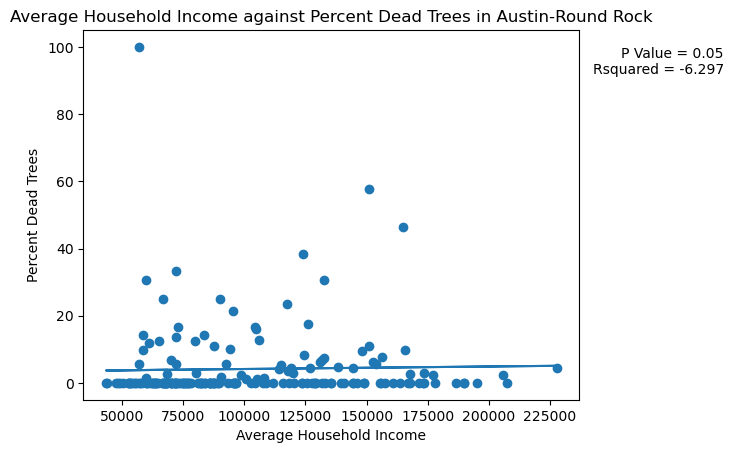

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 207 entries, 1084802 to 1101397
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   geometry                 207 non-null    geometry
 1   AMR8E001                 207 non-null    float64 
 2   VISIT_NBR                207 non-null    float64 
 3   STATECD                  207 non-null    float64 
 4   UNITCD                   207 non-null    float64 
 5   COUNTYCD                 207 non-null    float64 
 6   RETIRED_PLOT             207 non-null    float64 
 7   INTENSITY                207 non-null    float64 
 8   MEAS_YEAR                207 non-null    float64 
 9   MEAS_MONTH               207 non-null    float64 
 10  MEAS_DAY                 207 non-null    float64 
 11  KINDCD                   207 non-null    float64 
 12  PLOT_STATUS_CD           207 non-null    float64 
 13  PLOT_NONSAMPLE_REASN_CD  5 non-null      float6

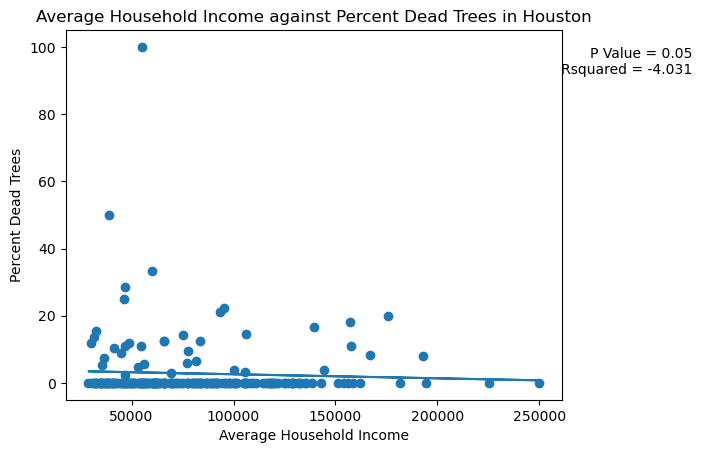

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 191 entries, 1057147 to 2469236
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   geometry                 191 non-null    geometry
 1   AMR8E001                 191 non-null    float64 
 2   VISIT_NBR                191 non-null    float64 
 3   STATECD                  191 non-null    float64 
 4   UNITCD                   191 non-null    float64 
 5   COUNTYCD                 191 non-null    float64 
 6   RETIRED_PLOT             191 non-null    float64 
 7   INTENSITY                191 non-null    float64 
 8   MEAS_YEAR                191 non-null    float64 
 9   MEAS_MONTH               191 non-null    float64 
 10  MEAS_DAY                 191 non-null    float64 
 11  KINDCD                   191 non-null    float64 
 12  PLOT_STATUS_CD           191 non-null    float64 
 13  PLOT_NONSAMPLE_REASN_CD  2 non-null      float6

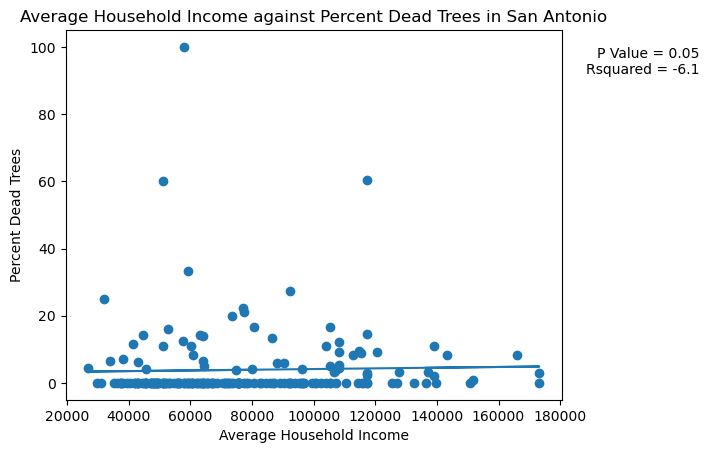

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 122 entries, 2953488 to 2928433
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   geometry                 122 non-null    geometry
 1   AMR8E001                 122 non-null    float64 
 2   VISIT_NBR                122 non-null    float64 
 3   STATECD                  122 non-null    float64 
 4   UNITCD                   122 non-null    float64 
 5   COUNTYCD                 122 non-null    float64 
 6   RETIRED_PLOT             122 non-null    float64 
 7   INTENSITY                122 non-null    float64 
 8   MEAS_YEAR                122 non-null    float64 
 9   MEAS_MONTH               122 non-null    float64 
 10  MEAS_DAY                 122 non-null    float64 
 11  KINDCD                   122 non-null    float64 
 12  PLOT_STATUS_CD           122 non-null    float64 
 13  PLOT_NONSAMPLE_REASN_CD  0 non-null      float6

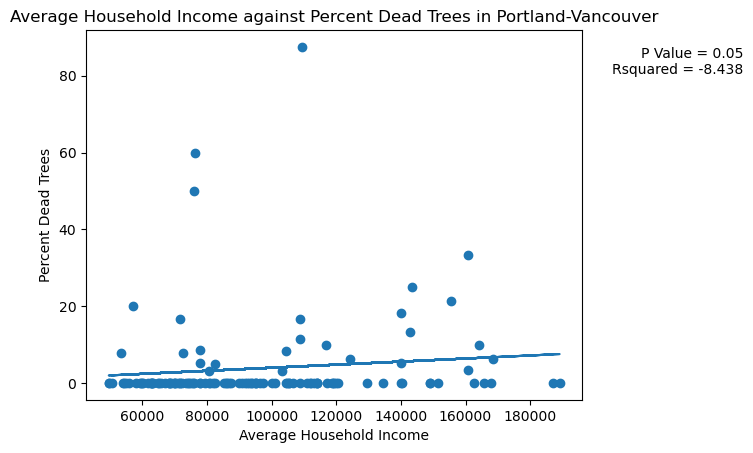

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 97 entries, 2070326 to 2074803
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   geometry                 97 non-null     geometry
 1   AMR8E001                 97 non-null     float64 
 2   VISIT_NBR                97 non-null     float64 
 3   STATECD                  97 non-null     float64 
 4   UNITCD                   97 non-null     float64 
 5   COUNTYCD                 97 non-null     float64 
 6   RETIRED_PLOT             97 non-null     float64 
 7   INTENSITY                97 non-null     float64 
 8   MEAS_YEAR                97 non-null     float64 
 9   MEAS_MONTH               97 non-null     float64 
 10  MEAS_DAY                 97 non-null     float64 
 11  KINDCD                   97 non-null     float64 
 12  PLOT_STATUS_CD           97 non-null     float64 
 13  PLOT_NONSAMPLE_REASN_CD  1 non-null      float64

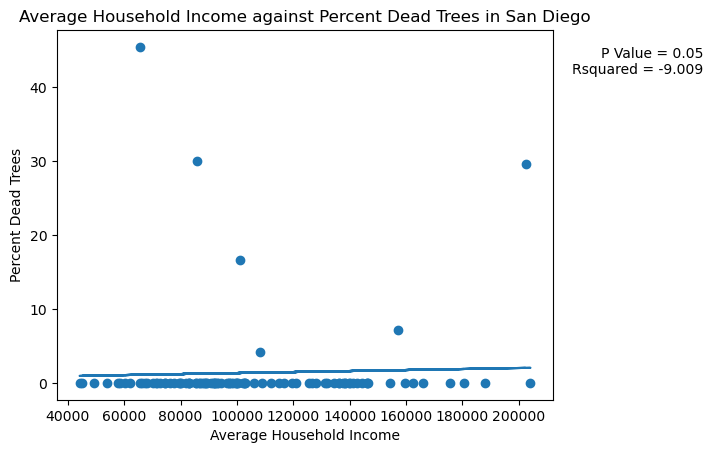

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 83 entries, 1472750 to 1471223
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   geometry                 83 non-null     geometry
 1   AMR8E001                 83 non-null     float64 
 2   VISIT_NBR                83 non-null     float64 
 3   STATECD                  83 non-null     float64 
 4   UNITCD                   83 non-null     float64 
 5   COUNTYCD                 83 non-null     float64 
 6   RETIRED_PLOT             83 non-null     float64 
 7   INTENSITY                83 non-null     float64 
 8   MEAS_YEAR                83 non-null     float64 
 9   MEAS_MONTH               83 non-null     float64 
 10  MEAS_DAY                 83 non-null     float64 
 11  KINDCD                   83 non-null     float64 
 12  PLOT_STATUS_CD           83 non-null     float64 
 13  PLOT_NONSAMPLE_REASN_CD  2 non-null      float64

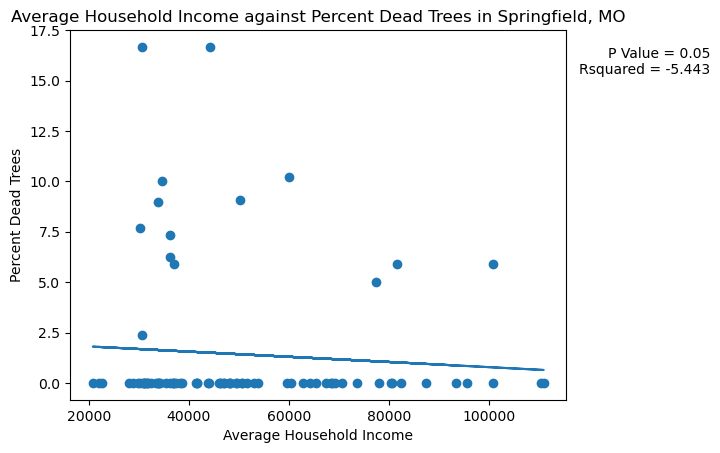

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 181 entries, 1678209 to 1434936
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   geometry                 181 non-null    geometry
 1   AMR8E001                 181 non-null    float64 
 2   VISIT_NBR                181 non-null    float64 
 3   STATECD                  181 non-null    float64 
 4   UNITCD                   181 non-null    float64 
 5   COUNTYCD                 181 non-null    float64 
 6   RETIRED_PLOT             181 non-null    float64 
 7   INTENSITY                181 non-null    float64 
 8   MEAS_YEAR                181 non-null    float64 
 9   MEAS_MONTH               181 non-null    float64 
 10  MEAS_DAY                 181 non-null    float64 
 11  KINDCD                   181 non-null    float64 
 12  PLOT_STATUS_CD           181 non-null    float64 
 13  PLOT_NONSAMPLE_REASN_CD  3 non-null      float6

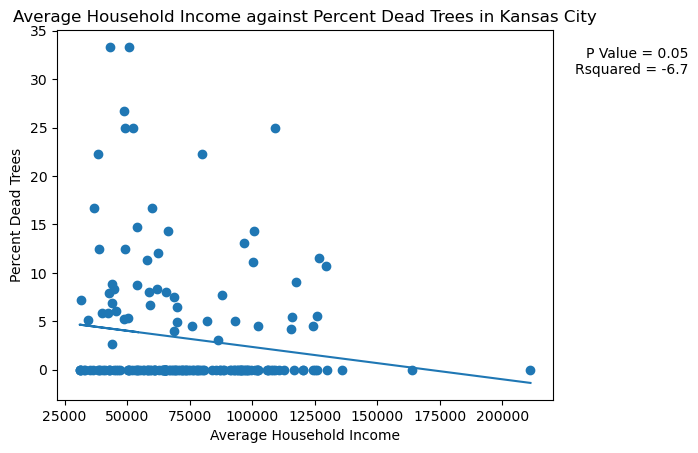

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 263 entries, 1488888 to 1816474
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   geometry                 263 non-null    geometry
 1   AMR8E001                 263 non-null    float64 
 2   VISIT_NBR                263 non-null    float64 
 3   STATECD                  263 non-null    float64 
 4   UNITCD                   263 non-null    float64 
 5   COUNTYCD                 263 non-null    float64 
 6   RETIRED_PLOT             263 non-null    float64 
 7   INTENSITY                263 non-null    float64 
 8   MEAS_YEAR                263 non-null    float64 
 9   MEAS_MONTH               263 non-null    float64 
 10  MEAS_DAY                 263 non-null    float64 
 11  KINDCD                   263 non-null    float64 
 12  PLOT_STATUS_CD           263 non-null    float64 
 13  PLOT_NONSAMPLE_REASN_CD  8 non-null      float6

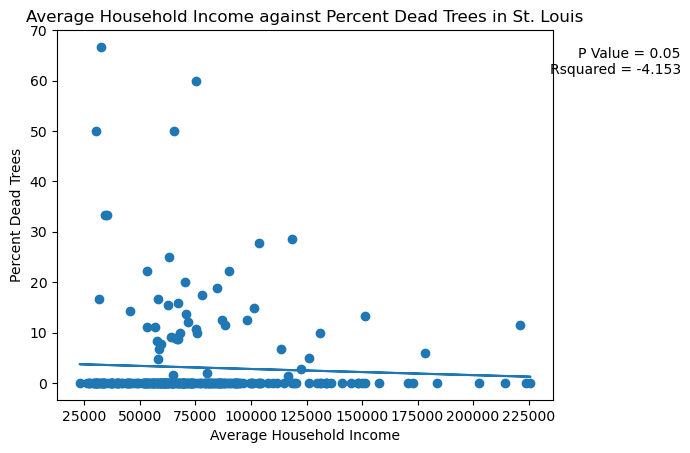

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 140 entries, 3002428 to 1039189
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   geometry                 140 non-null    geometry
 1   AMR8E001                 140 non-null    float64 
 2   VISIT_NBR                140 non-null    float64 
 3   STATECD                  140 non-null    float64 
 4   UNITCD                   140 non-null    float64 
 5   COUNTYCD                 140 non-null    float64 
 6   RETIRED_PLOT             140 non-null    float64 
 7   INTENSITY                140 non-null    float64 
 8   MEAS_YEAR                140 non-null    float64 
 9   MEAS_MONTH               140 non-null    float64 
 10  MEAS_DAY                 140 non-null    float64 
 11  KINDCD                   140 non-null    float64 
 12  PLOT_STATUS_CD           140 non-null    float64 
 13  PLOT_NONSAMPLE_REASN_CD  12 non-null     float6

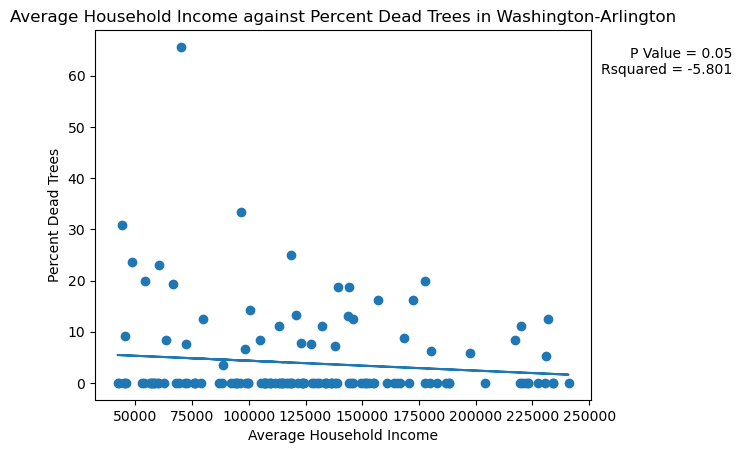

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 175 entries, 1837534 to 1467836
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   geometry                 175 non-null    geometry
 1   AMR8E001                 175 non-null    float64 
 2   VISIT_NBR                175 non-null    float64 
 3   STATECD                  175 non-null    float64 
 4   UNITCD                   175 non-null    float64 
 5   COUNTYCD                 175 non-null    float64 
 6   RETIRED_PLOT             175 non-null    float64 
 7   INTENSITY                175 non-null    float64 
 8   MEAS_YEAR                175 non-null    float64 
 9   MEAS_MONTH               175 non-null    float64 
 10  MEAS_DAY                 175 non-null    float64 
 11  KINDCD                   175 non-null    float64 
 12  PLOT_STATUS_CD           175 non-null    float64 
 13  PLOT_NONSAMPLE_REASN_CD  0 non-null      float6

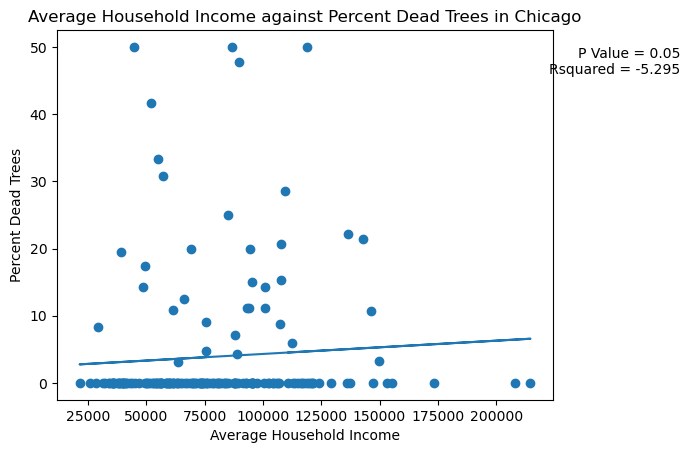

In [48]:
#Create directory to store figures
# Directory 
directory = dataVars + " against " + treeVars
# Path - Parent dir set in variables at top
path = os.path.join(parent_dir, directory) 
try: 
    os.mkdir(path) 
except OSError as error: 
    print("Folder Exists - Skipping to Graphs")  
#Convert metro area information to albers
metroA = metro.to_crs("ESRI:102003")
#filter metro information for only cities needed
metroA = metroA[metroA['NAME'].str.contains('|'.join(cities))]
for i in range(len(cities)):
    city = cities[i]
    #filter metro area again for specific city.
    metroCity = metroA[metroA['NAME'].str.contains(city)]
    #Clip plots by selected city
    clip = gpd.clip(dissolve,metroCity)
    #Plot biomass against income
    print(clip.info())
    plt.scatter(clip[dataString], clip[treeVar])
    #z = np.polyfit(intersect['AMR8E001'], intersect['TOTAL_LENGTH'],1)
    #p = np.poly1d(z)
    z = np.polyfit(clip[dataString], clip[treeVar], 1)

    p = np.poly1d(z)

    #add trendline to plot
    plt.plot(clip[dataString], p(clip[dataString]))\
    
    #Ptest
    q = .05
    df = len(clip[dataString])-1
    t=scipy.stats.t.ppf(q,df)
    ps=scipy.stats.t.sf(abs(t),df)
    ps = str(round(ps,3))
    
    #R Squared test
    r2 = (r2_score(clip[dataString], p(clip[dataString])))
    r2 = str(round(r2,3))
    plt.text(max(clip[dataString])*1.3,max(clip[treeVar]),"P Value = " + ps + "\nRsquared = " + r2,
            horizontalalignment = 'right',
            verticalalignment = 'top')
    
    plt.title(dataVars + " against " + treeVars + " in " + city)
    plt.xlabel(dataVars)
    plt.ylabel(treeVars)
    #plt.plot(intersect['AMR8E001'],p(intersect['AMR8E001']))
    #Save figures to directory
    plt.savefig('figures/'+ dataVars + " against " + treeVars + '/' +city+ '.png')
    plt.show()

